<a href="https://colab.research.google.com/github/Elman295/Maximum-Classifier-Discrepancy-for-Unsupervised-Domain-Adaptation/blob/main/MNIST_2_USPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch import nn

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

#`Data`

In [ ]:
tfms = transforms.Compose([
    transforms.Resize(size = (28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.5, std = 0.5)
])

In [ ]:
MNIST_train = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = tfms
)

MNIST_test = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = tfms
)

USPS_train = datasets.USPS(
    root = "data",
    train = True,
    download = True,
    transform = tfms
)

USPS_test = datasets.USPS(
    root = "data",
    train = False,
    download = True,
    transform = tfms
)

In [88]:
source_train_dl = DataLoader(dataset = MNIST_train, batch_size = 128, shuffle = True)
source_test_dl = DataLoader(dataset = MNIST_test, batch_size = 128, shuffle = False)

target_train_dl = DataLoader(dataset=USPS_train, batch_size = 128, shuffle = True)
target_test_dl = DataLoader(dataset = USPS_test, batch_size=128, shuffle = False)

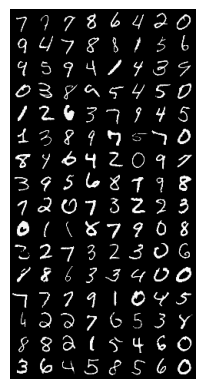

In [89]:
image, label = next(iter(source_train_dl))
outs = torchvision.utils.make_grid(image)

plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()

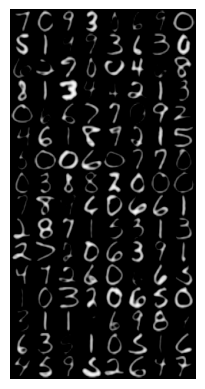

In [90]:
image, label = next(iter(target_train_dl))
outs = torchvision.utils.make_grid(image)

plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()

#`Functions`

In [91]:
def discrepancy_loss(f1,f2):
  return torch.mean(torch.abs(F.softmax(f1) - F.softmax(f2)))

In [92]:
loss_ce = nn.CrossEntropyLoss()

#`Models`

In [93]:
class Generator(nn.Module):
    """LeNet encoder model for ADDA."""

    def __init__(self):
      super(Generator, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
      self.bn1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 48, kernel_size=5, stride=1)
      self.bn2 = nn.BatchNorm2d(48)

    def forward(self, x):
        x = torch.mean(x,1).view(x.size()[0],1,x.size()[2],x.size()[3])
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), stride=2, kernel_size=2, dilation=(1, 1))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), stride=2, kernel_size=2, dilation=(1, 1))
        #print(x.size())
        x = x.view(x.size(0), 48*4*4)
        return x

In [94]:
class Classifier(nn.Module):
    def __init__(self, prob=0.5):
          super(Classifier, self).__init__()
          self.fc1 = nn.Linear(48*4*4, 100)
          self.bn1_fc = nn.BatchNorm1d(100)
          self.fc2 = nn.Linear(100, 100)
          self.bn2_fc = nn.BatchNorm1d(100)
          self.fc3 = nn.Linear(100, 10)
          self.bn_fc3 = nn.BatchNorm1d(10)
          self.prob = prob

    def set_lambda(self, lambd):
        self.lambd = lambd
    def forward(self, x):
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn1_fc(self.fc1(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn2_fc(self.fc2(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = self.fc3(x)
        return x

In [95]:
G = Generator().to(device)
F1 = Classifier().to(device)
F2 = Classifier().to(device)

In [96]:
for p in F1.parameters():
  print(p)

Parameter containing:
tensor([[ 0.0004, -0.0236,  0.0266,  ..., -0.0232, -0.0336, -0.0038],
        [-0.0142,  0.0355, -0.0218,  ...,  0.0302, -0.0248, -0.0329],
        [-0.0104,  0.0188,  0.0175,  ...,  0.0285,  0.0104, -0.0217],
        ...,
        [ 0.0170,  0.0155,  0.0165,  ..., -0.0138, -0.0035,  0.0268],
        [-0.0065,  0.0315,  0.0240,  ...,  0.0357,  0.0296,  0.0289],
        [-0.0155, -0.0015,  0.0359,  ...,  0.0155, -0.0022, -0.0237]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 1.4638e-02,  2.5166e-02, -4.0835e-03,  1.4049e-02, -2.3179e-02,
         2.9625e-02, -3.6797e-03, -1.0935e-03, -2.1603e-02,  4.2210e-03,
        -3.7311e-03, -3.2610e-02,  8.3619e-05,  4.0866e-03, -1.0404e-02,
        -1.5596e-02,  1.5481e-02,  2.3007e-02, -2.1628e-02,  1.3133e-03,
         2.3175e-02, -2.6987e-02,  1.6724e-02,  1.5002e-02, -3.0635e-02,
         3.3625e-03, -1.6045e-02,  5.8710e-03, -3.0591e-02,  1.9089e-02,
         1.7000e-02, -2.4624e-02,  3.119

In [97]:
for p in F2.parameters():
  print(p)

Parameter containing:
tensor([[ 0.0214,  0.0014,  0.0359,  ...,  0.0048, -0.0020, -0.0229],
        [-0.0283,  0.0319,  0.0104,  ...,  0.0279,  0.0150,  0.0039],
        [ 0.0151, -0.0023, -0.0353,  ...,  0.0088,  0.0277,  0.0186],
        ...,
        [ 0.0309,  0.0197, -0.0097,  ..., -0.0060, -0.0268,  0.0205],
        [-0.0290,  0.0181, -0.0168,  ..., -0.0037, -0.0083, -0.0038],
        [-0.0143,  0.0201, -0.0308,  ...,  0.0015,  0.0198, -0.0112]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-7.4248e-03, -1.5176e-02,  1.8529e-02,  4.4402e-03,  1.8571e-02,
         2.2324e-02,  9.9199e-03,  3.0647e-02, -6.3744e-03,  1.9593e-02,
        -2.5659e-02,  3.3367e-02, -2.7647e-02,  2.2927e-02,  1.2086e-03,
         3.5939e-02,  3.0679e-05, -3.1500e-02,  1.1071e-02,  1.9188e-02,
        -1.4039e-03, -2.6391e-02,  2.4596e-02,  1.7718e-02, -5.0109e-03,
         1.3249e-02, -1.8707e-02,  3.5086e-02,  9.4566e-03, -1.5512e-02,
        -5.6899e-03,  4.3139e-03,  1.730

In [98]:
x = torch.rand(size = (32,1,28,28)).to(device)
g = G(x)
f1 = F1(g)
f2 = F2(g)

print(f1 == f2)
print(f1.shape)

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, Fal

#`Optimizers`

In [99]:
G_opt = torch.optim.Adam(params = G.parameters(), lr =  1e-4)
F1_opt = torch.optim.Adam(params = F1.parameters(), lr =  1e-4)
F2_opt = torch.optim.Adam(params = F2.parameters(), lr =  1e-4)

#`Train`

In [100]:
def train(data_s, data_t, G, F1, F2, loss_ce, discrepancy_loss, G_opt, F1_opt, F2_opt, N):
  G.train()
  F1.train()
  F2.train()

  size = len(data_s.dataset)

  for b, ((x_s,y_s),(x_t,_)) in enumerate(zip(data_s, data_t)):

    x_s, y_s, x_t = x_s.to(device), y_s.to(device), x_t.to(device)

    # stepA

    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    fs_A = G(x_s)
    y1_s_A = F1(fs_A)
    y2_s_A = F2(fs_A)

    loss_1_A = loss_ce(y1_s_A, y_s)
    loss_2_A = loss_ce(y2_s_A, y_s)
    lossA = loss_1_A + loss_2_A

    lossA.backward()

    G_opt.step()
    F1_opt.step()
    F2_opt.step()


    # stepB


    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    fs_B = G(x_s)
    y1_s_B = F1(fs_B)
    y2_s_B = F2(fs_B)
    loss_1_B = loss_ce(y1_s_B, y_s)
    loss_2_B = loss_ce(y2_s_B, y_s)
    loss_ce_B = loss_1_B + loss_2_B

    ft_B = G(x_t)
    y1_t_B = F1(ft_B)
    y2_t_B = F2(ft_B)
    loss_adv = discrepancy_loss(y1_t_B, y2_t_B)

    lossB = loss_ce_B - loss_adv

    lossB.backward()
    F1_opt.step()
    F2_opt.step()

    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    # stepC

    for n in range(N):
      ft_C = G(x_t)
      y1_t_C = F1(ft_C)
      y2_t_C = F2(ft_C)
      lossC = discrepancy_loss(y1_t_C, y2_t_C)
      lossC.backward()
      G_opt.step()

      G_opt.zero_grad()
      F1_opt.zero_grad()
      F2_opt.zero_grad()


  if b % 100 == 0:
    print(f"lossA:{lossA.item()} lossB:{lossB.item()} lossC:{lossC.item()}")

#`Test`

In [101]:
def test(data, G, F1, F2, loss_ce):

  G.eval()
  F1.eval()
  F2.eval()

  size = len(data.dataset)
  num_batch = len(data)

  test_acc_1, test_loss_1 = 0,0
  test_acc_2, test_loss_2 = 0,0

  with torch.no_grad():
    for x,y in data:
      x,y = x.to(device), y.to(device)

      f = G(x)
      y1 = F1(f)
      y2 = F2(f)
      test_loss_1 += loss_ce(y1,y).item()
      test_loss_2 += loss_ce(y2,y).item()
      test_acc_1 += (y1.argmax(1) == y).type(torch.float).sum().item()
      test_acc_2 += (y2.argmax(1) == y).type(torch.float).sum().item()


    test_loss_1 /= num_batch
    test_loss_2 /= num_batch

    test_acc_1 /= size
    test_acc_2 /= size

    print(f"F1 loss : {test_loss_1} F1 accuracy: {test_acc_1 * 100}")
    print(f"F2 loss : {test_loss_2} F2 accuracy: {test_acc_2 * 100}")

#`Training`

In [102]:
for epoch in range(70):
  print(f"epoch : {epoch+1}=-=-=-=-=-=-")
  train(source_train_dl, target_train_dl, G, F1, F2, loss_ce, discrepancy_loss, G_opt, F1_opt, F2_opt, N = 1)
  print(f"target:")
  test(target_train_dl, G, F1, F2, loss_ce)
  print("source:")
  test(source_test_dl, G, F1, F2, loss_ce)

epoch : 1=-=-=-=-=-=-


<ipython-input-91-a642ba8e7794>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.mean(torch.abs(F.softmax(f1) - F.softmax(f2)))


target:
F1 loss : 1.965283096882335 F1 accuracy: 39.98079824441092
F2 loss : 1.9672153037891054 F2 accuracy: 41.91468934302564
source:
F1 loss : 1.613148319570324 F1 accuracy: 75.46000000000001
F2 loss : 1.5357370799100851 F2 accuracy: 76.72
epoch : 2=-=-=-=-=-=-
target:
F1 loss : 1.7684551163723594 F1 accuracy: 43.39596763132629
F2 loss : 1.7723287657687539 F2 accuracy: 42.94335482101221
source:
F1 loss : 1.192090954961656 F1 accuracy: 82.94
F2 loss : 1.0444914653331419 F2 accuracy: 84.33
epoch : 3=-=-=-=-=-=-
target:
F1 loss : 1.6190271858583416 F1 accuracy: 47.4283363050336
F2 loss : 1.6217929208487796 F2 accuracy: 45.316143190234534
source:
F1 loss : 0.8707801993889145 F1 accuracy: 86.0
F2 loss : 0.7430777881718889 F2 accuracy: 88.82
epoch : 4=-=-=-=-=-=-
target:
F1 loss : 1.5919783596406902 F1 accuracy: 44.479495268138805
F2 loss : 1.619628209816782 F2 accuracy: 42.394733232752706
source:
F1 loss : 0.6726198626469962 F1 accuracy: 87.56
F2 loss : 0.5793574226053455 F2 accuracy: 90.